# Problem Statement

Using the data collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

## 1. Import libraries and load dataset

In [136]:
#Import all the necessary modules

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.model_selection import StratifiedKFold

from yellowbrick.classifier import ClassificationReport, ROCAUC
from yellowbrick.model_selection import FeatureImportances

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from IPython.display import Image  
import pydotplus
import graphviz

from datetime import datetime
num_bins = 10

In [5]:
df= pd.read_csv(r'C:\Users\zehra.hussain\DataScience\Course\Ensemble Techniques\data\bank-full.csv')

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Attribute Description:

    1.age:Continuous feature 
    2.job:Type of job (management, technician, entrepreneur, blue-collar, etc.)
    3.marital: marital status(married, single, divorced)
    4.education:education level (primary, secondary, tertiary)
    5.default: has credit in default? 
    6.housing: has housing loan? 
    7.loan: has personal loan?
    8.balance in accountRelated to previous contact:
    9.contact: contact communication type
    10.month: last contact month of year
    11.day: last contact day of the month
    12.duration: last contact duration, in seconds*Other attributes:
    13.campaign: number of contacts performed during this campaign and for this client
    14.pdays: number of days that passed by after the client was last contacted from a previous campaign(-1 tells us the person has not been contacted or contact period is beyond 900 days)
    15.previous: number of contacts performed before this campaign and for this client
    16.poutcome: outcome of the previous marketing campaignOutput variable (desired target)
    17.Target: Tell us has the client subscribed a term deposit. (Yes, No)


In [7]:
df.shape

(45211, 17)

## 2. Check Data Types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Convert object data type to categorical 

In [9]:
for feature in df.columns: # Loop through all columns in the dataframe
    if df[feature].dtype == 'object': # Only apply for columns with categorical strings
        df[feature] = pd.Categorical(df[feature])# Replace strings with an integer
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  Target     45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


### Check for null values

In [11]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

## Summary Stats

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


## Analyze Distributions 

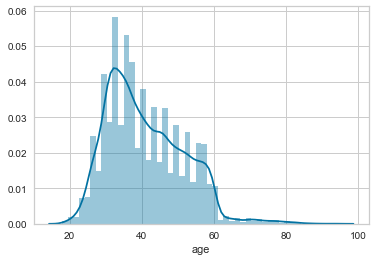

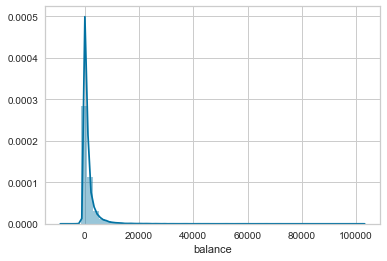

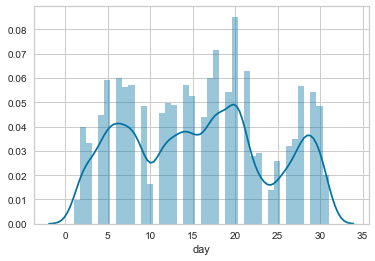

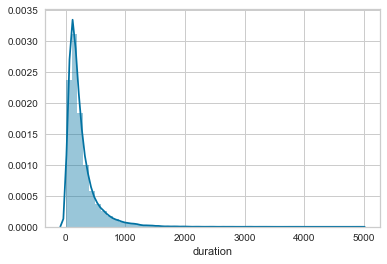

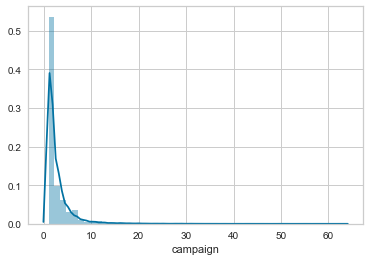

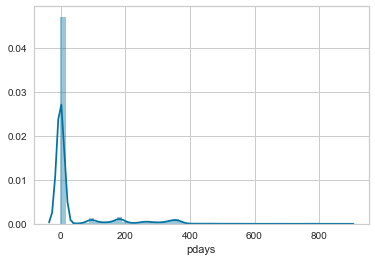

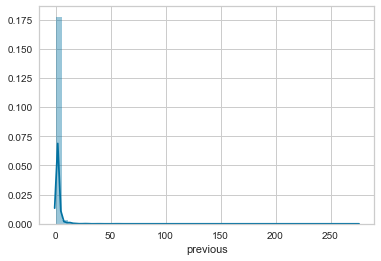

In [13]:
for i in list(['age', 'balance', 'day', 'duration',
       'campaign', 'pdays', 'previous']):  
    sns.distplot(df[i])
    plt.show()

### Normalize 

### Balance is skewed with a long tail - lets normalize balance

In [14]:
std_scale = StandardScaler()
df['balance_transform'] = std_scale.fit_transform(df[['balance']])

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
df['balance_transform'].head()

0    0.256419
1   -0.437895
2   -0.446762
3    0.047205
4   -0.447091
Name: balance_transform, dtype: float64

In [16]:
df['balance_transform'].describe()

count    4.521100e+04
mean     3.070663e-15
std      1.000011e+00
min     -3.081149e+00
25%     -4.237719e-01
50%     -3.002800e-01
75%      2.158743e-02
max      3.309478e+01
Name: balance_transform, dtype: float64

In [17]:
df['duration_transform'] = std_scale.fit_transform(df[['duration']])

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [18]:
df['duration_transform'].describe()

count    4.521100e+04
mean     5.560938e-17
std      1.000011e+00
min     -1.002478e+00
25%     -6.025167e-01
50%     -3.035165e-01
75%      2.362370e-01
max      1.809470e+01
Name: duration_transform, dtype: float64

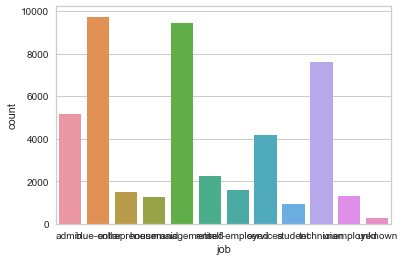

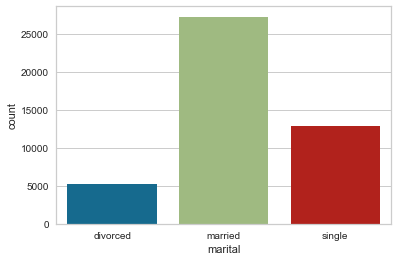

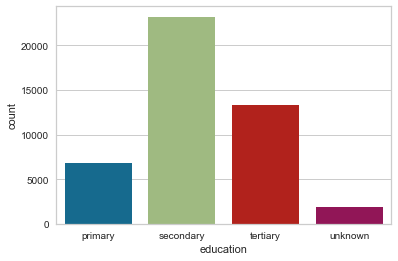

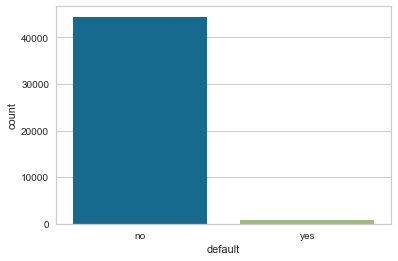

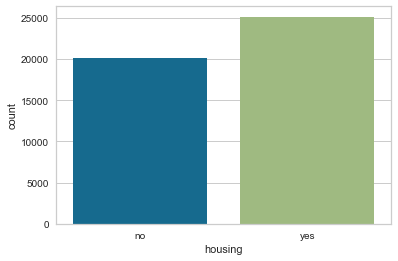

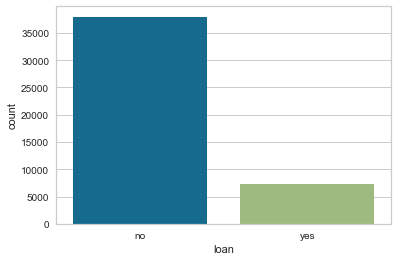

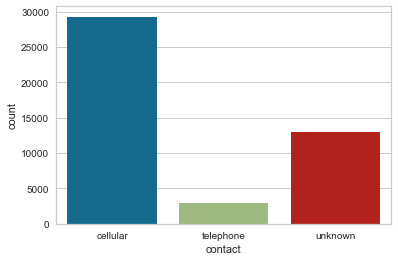

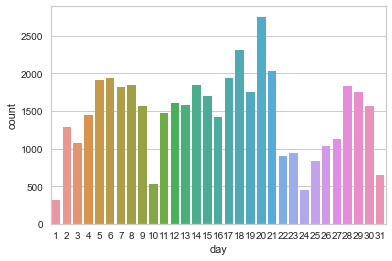

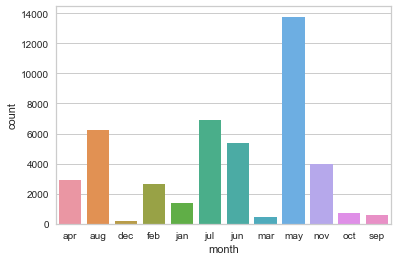

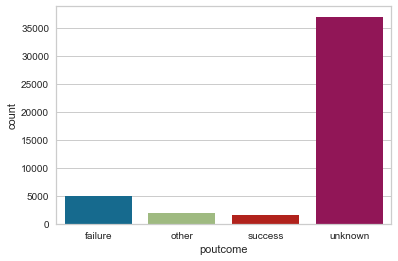

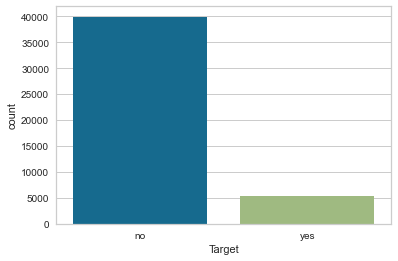

In [19]:
for i in list(['job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'Target']): 
     sns.countplot(df[i])
     plt.show()

In [20]:
for i in list(['job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'Target']):  
    print(df[i].value_counts(normalize=True))
    print()


blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: job, dtype: float64

married     0.601933
single      0.282896
divorced    0.115171
Name: marital, dtype: float64

secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: education, dtype: float64

no     0.981973
yes    0.018027
Name: default, dtype: float64

yes    0.555838
no     0.444162
Name: housing, dtype: float64

no     0.839774
yes    0.160226
Name: loan, dtype: float64

cellular     0.647741
unknown      0.287983
telephone    0.064276
Name: contact, dtype: float64

20    0.060870
18    0.051050
21    0.044812
17    0.042888
6     0.042733
5     0.042246
14    0.040875
8     0.040742
28    0.040477
7     0.040189
19    0.03886

### Conclusion
    Balance and duration was normalized
    No missing values
    Target is 11% of the entire population
    81% of the outcomes from the previous campaigns are unknown

### Correlations 

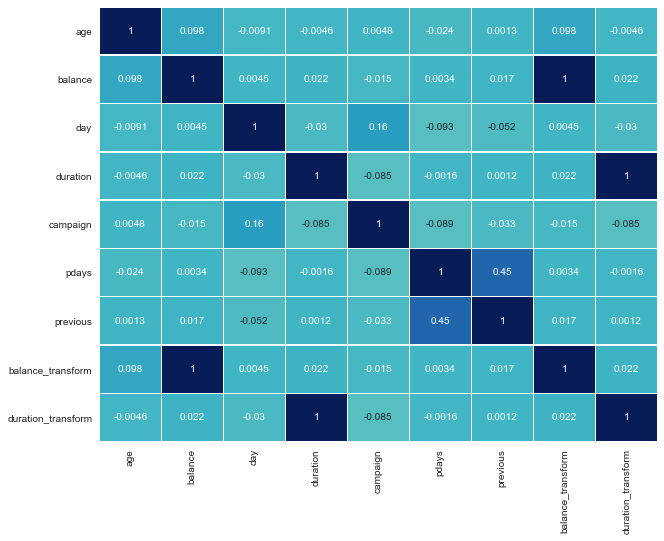

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

#### Conclusion
    p days and previous has a strong correlation

### Analyze Target Variable in relation to other independent features

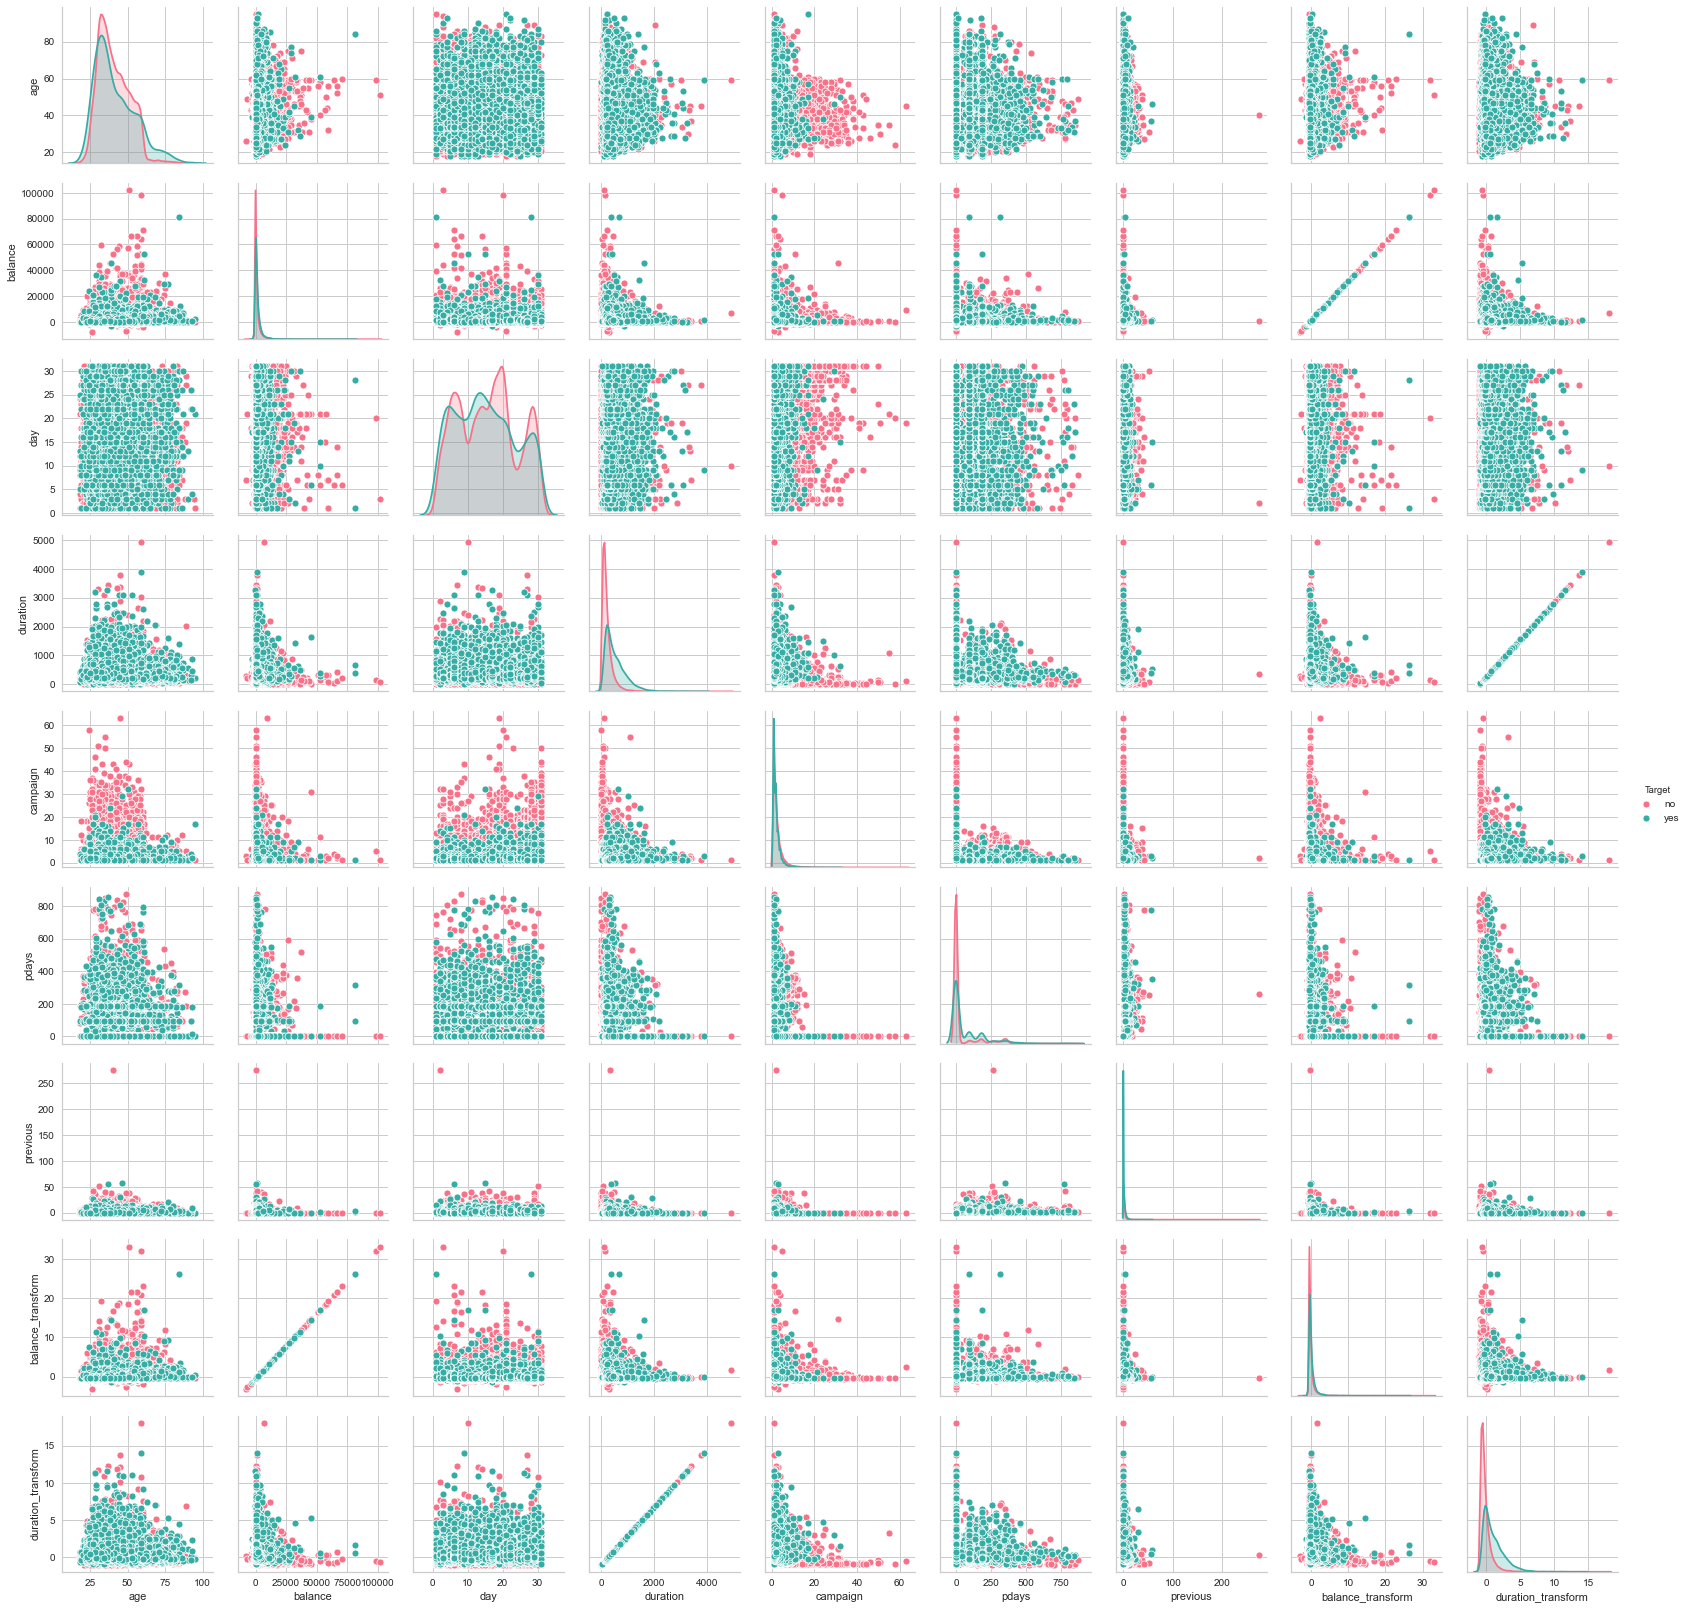

In [22]:
sns.pairplot(df, hue="Target", palette="husl")

In [23]:
df.groupby(["Target"]).mean()

,age,balance,day,duration,campaign,pdays,previous,balance_transform,duration_transform
Target,,,,,,,,,
no,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154,-0.019232,-0.143599
yes,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354,0.145167,1.083901


In [24]:
df.groupby(["Target"]).median()

,age,balance,day,duration,campaign,pdays,previous,balance_transform,duration_transform
Target,,,,,,,,,
no,39,417,16,164,2,-1,0,-0.310461,-0.365646
yes,38,733,15,426,2,-1,0,-0.206676,0.651731


In [25]:
pd.crosstab(df['job'],df['Target'],normalize='index')

Target,no,yes
job,,
admin.,0.877973,0.122027
blue-collar,0.927250,0.072750
entrepreneur,0.917283,0.082717
housemaid,0.912097,0.087903
management,0.862444,0.137556
retired,0.772085,0.227915
self-employed,0.881571,0.118429
services,0.911170,0.088830
student,0.713220,0.286780


In [26]:
pd.crosstab(df['Target'],df['job'],normalize='index')

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
Target,,,,,,,,,,,,
no,0.113722,0.226041,0.034167,0.028330,0.204323,0.043785,0.034868,0.094810,0.016758,0.169255,0.027579,0.006362
yes,0.119304,0.133863,0.023256,0.020609,0.245982,0.097561,0.035356,0.069767,0.050860,0.158820,0.038192,0.006428


In [27]:
pd.crosstab(df['Target'],df['marital'],normalize='index')

marital,divorced,married,single
Target,,,
no,0.114849,0.612670,0.272481
yes,0.117603,0.520892,0.361505


In [28]:
pd.crosstab(df['Target'],df['education'],normalize='index')

education,primary,secondary,tertiary,unknown
Target,,,,
no,0.156806,0.519814,0.283177,0.040203
yes,0.111741,0.463226,0.377387,0.047646


In [29]:
pd.crosstab(df['Target'],df['default'],normalize='index')

default,no,yes
Target,,
no,0.980888,0.019112
yes,0.990168,0.009832


In [30]:
pd.crosstab(df['Target'],df['housing'],normalize='index')

housing,no,yes
Target,,
no,0.418992,0.581008
yes,0.634146,0.365854


In [31]:
pd.crosstab(df['Target'],df['loan'],normalize='index')

loan,no,yes
Target,,
no,0.830670,0.169330
yes,0.908489,0.091511


In [32]:
pd.crosstab(df['Target'],df['poutcome'],normalize='index')

poutcome,failure,other,success,unknown
Target,,,,
no,0.107284,0.038400,0.013351,0.840965
yes,0.116846,0.058045,0.184912,0.640197


In [33]:
pd.crosstab(df['poutcome'],df['Target'],normalize='index')

Target,no,yes
poutcome,,
failure,0.873903,0.126097
other,0.833152,0.166848
success,0.352747,0.647253
unknown,0.908385,0.091615


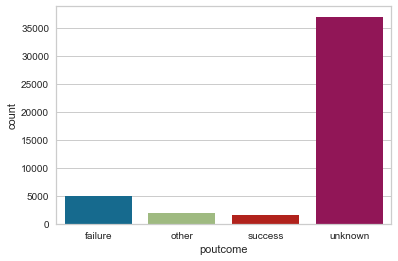

In [34]:
sns.countplot(df['poutcome'])

## Observations

1. Entreprenuer, Management and Admins are more likely to get term deposits

2. There are more married people in the dataset. I noticed a higher propotion of Single people in the target population as well

3. 37% of the target population has tertiary education

4. Target populationare not usually defaulters on loans

5. Majority of the target population do not own their own housing

6. 18% of the target have had success from the pervious campaign

7. Target audience is slightly older in age

8. Target audience maintain higher balance

9. The target population has a hugher number of contacts performed during this campaign 

10. The target population seems to have higher number of days that passed by after the client was last contacted from a previous campaign
 
11. They have a higher number of contacts performed before this campaign

12. They also have a higher call duration 



## Get data ready 

In [35]:
df = df.drop('balance', axis=1)

In [36]:
df = df.drop('duration', axis=1)

In [37]:
df.head()

,age,job,marital,education,default,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,Target,balance_transform,duration_transform
0,58,management,married,tertiary,no,yes,no,unknown,5,may,1,-1,0,unknown,no,0.256419,0.011016
1,44,technician,single,secondary,no,yes,no,unknown,5,may,1,-1,0,unknown,no,-0.437895,-0.416127
2,33,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,1,-1,0,unknown,no,-0.446762,-0.707361
3,47,blue-collar,married,unknown,no,yes,no,unknown,5,may,1,-1,0,unknown,no,0.047205,-0.645231
4,33,unknown,single,unknown,no,no,no,unknown,5,may,1,-1,0,unknown,no,-0.447091,-0.233620


In [38]:
df['Target'] = df['Target'].replace('yes',1)
df['Target'] = df['Target'].replace('no',0)

# 3.Split  data into training and test 

In [57]:
## Define X and Y variables
X = df.drop('Target', axis=1)
Y = df[['Target']]

In [58]:
X = pd.get_dummies(X, drop_first=True)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30,random_state=1)

## Logistic Regression

In [60]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=20)
logreg.fit(X_train, y_train)

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=20, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
logreg_predict = logreg.predict(X_test)

In [62]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Logistic Regression'], 'Accuracy': logreg.score(X_test, y_test)
                         ,'Recall' : recall_score(y_test,logreg_predict), 'Precision': precision_score(y_test,logreg_predict)
                         ,'F1 Score' : f1_score(y_test,logreg_predict), 'Roc Auc Score': roc_auc_score(y_test,logreg_predict)})
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.90084,0.338491,0.622038,0.438413,0.655968


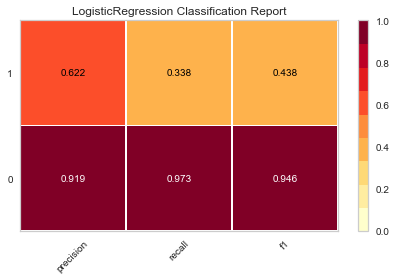

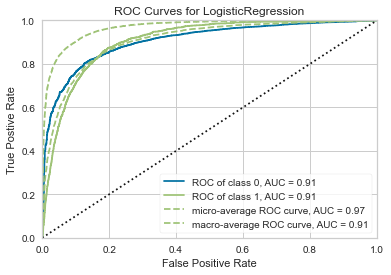

In [63]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(logreg)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(logreg)
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()


## Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
model_entropy=DecisionTreeClassifier(criterion='entropy')

In [65]:
model_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [66]:
model_entropy.score(X_train, y_train)  # performance on train data

1.0

In [67]:
model_entropy.score(X_test, y_test)  # performance on test data

0.87776467118844

In [68]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [69]:
print("Train: %.2f" % clf_pruned.score(X_train, y_train))  # performance on train data
print("Test: %.2f" % clf_pruned.score(X_test, y_test))  # performance on test data

Train: 0.90
Test: 0.90


In [70]:
y_DT = clf_pruned.predict(X_test)

In [71]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'Accuracy': clf_pruned.score(X_test, y_test)
                         ,'Recall' : recall_score(y_test,y_DT), 'Precision': precision_score(y_test,y_DT)
                         ,'F1 Score' : f1_score(y_test,y_DT), 'Roc Auc Score': roc_auc_score(y_test,y_DT)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.90084,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.90143,0.339136,0.627685,0.440352,0.656582


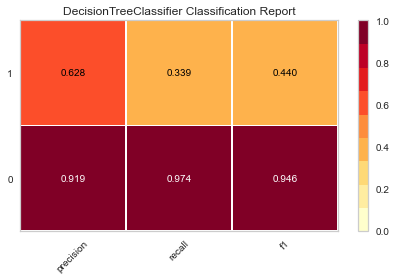

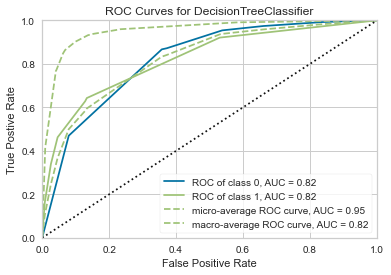

In [76]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(DecisionTreeClassifier(criterion = "entropy", max_depth=3))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(DecisionTreeClassifier(criterion = "entropy", max_depth=3))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

## Visualizing the tree

In [74]:
features = [col for col in X.columns]

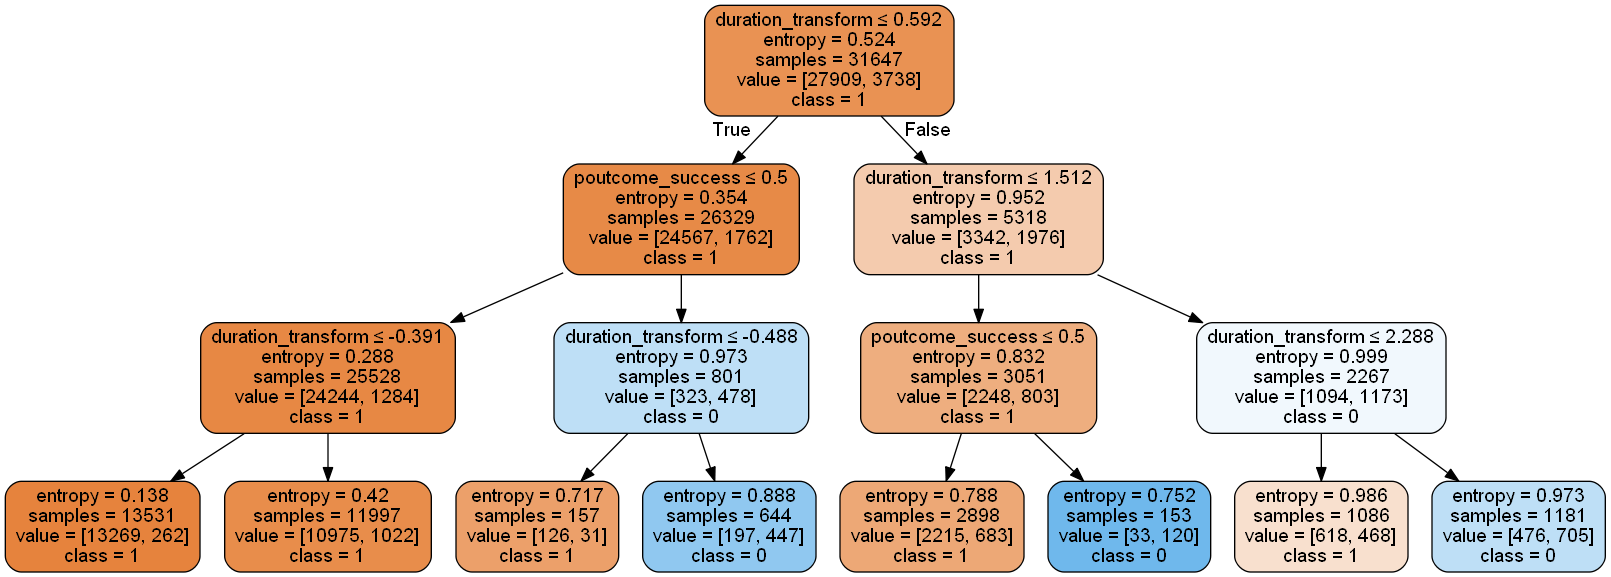

In [75]:
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features,class_names=['1','0'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('td_pruned.png')
Image(graph.create_png())

##  Feature Importance

In [82]:
## Calculating feature importance

feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)

feat_imp_dict = dict(zip(features, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)

,0
duration_transform,0.692217
poutcome_success,0.307783
age,0.000000
month_jan,0.000000
housing_yes,0.000000
loan_yes,0.000000
contact_telephone,0.000000
contact_unknown,0.000000
month_aug,0.000000
month_dec,0.000000


## Random Forest Model

In [83]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)

pred_RF = rfcl.predict(X_test)



C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'Accuracy': accuracy_score(y_test, pred_RF)
                         ,'Recall' : recall_score(y_test,pred_RF), 'Precision': precision_score(y_test,pred_RF)
                         ,'F1 Score' : f1_score(y_test,pred_RF), 'Roc Auc Score': roc_auc_score(y_test,pred_RF)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.90084,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.90143,0.339136,0.627685,0.440352,0.656582
0,Random Forest,0.90578,0.381689,0.649835,0.480910,0.677567


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\yellowbrick\base.py:359: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y, **kwargs)


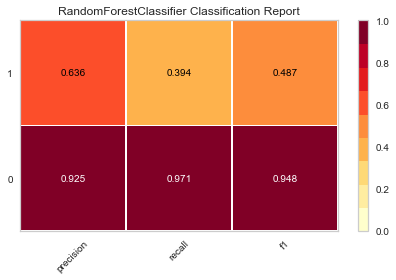

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\yellowbrick\base.py:359: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y, **kwargs)


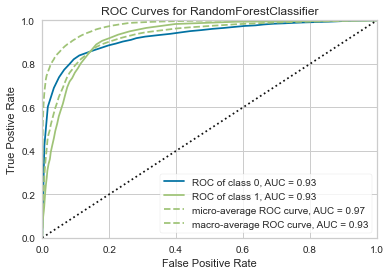

In [85]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(RandomForestClassifier(n_estimators = 50))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(RandomForestClassifier(n_estimators = 50))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

# Adaboost Ensemble Algorithm

In [86]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(n_estimators = 100, learning_rate=0.1, random_state=22)
abcl = abcl.fit(X_train, y_train)

pred_AB =abcl.predict(X_test)


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [87]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Adaboost'], 'Accuracy': accuracy_score(y_test, pred_AB)
                         ,'Recall' : recall_score(y_test,pred_AB), 'Precision': precision_score(y_test,pred_AB)
                         ,'F1 Score' : f1_score(y_test,pred_AB), 'Roc Auc Score': roc_auc_score(y_test,pred_AB)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.900840,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.901430,0.339136,0.627685,0.440352,0.656582
0,Random Forest,0.905780,0.381689,0.649835,0.480910,0.677567
0,Adaboost,0.897744,0.208897,0.669421,0.318428,0.597789


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


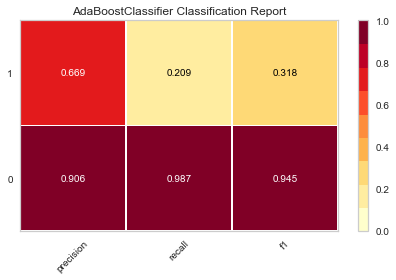

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


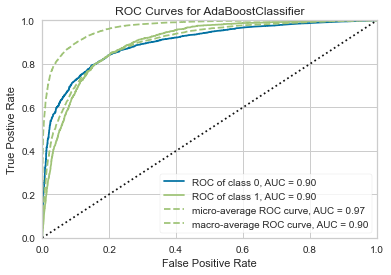

In [88]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(AdaBoostClassifier(n_estimators= 100, learning_rate=0.1, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

## Bagging Classifier

In [89]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22)
bgcl = bgcl.fit(X_train, y_train)

pred_BG = bgcl.predict(X_test)


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Bagging'], 'Accuracy': accuracy_score(y_test, pred_BG)
                         ,'Recall' : recall_score(y_test,pred_BG), 'Precision': precision_score(y_test,pred_BG)
                         ,'F1 Score' : f1_score(y_test,pred_BG), 'Roc Auc Score': roc_auc_score(y_test,pred_BG)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.900840,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.901430,0.339136,0.627685,0.440352,0.656582
0,Random Forest,0.905780,0.381689,0.649835,0.480910,0.677567
0,Adaboost,0.897744,0.208897,0.669421,0.318428,0.597789
0,Bagging,0.904895,0.466796,0.609941,0.528853,0.714127


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


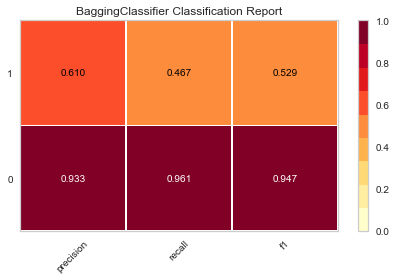

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\ensemble\bagging.py:622: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


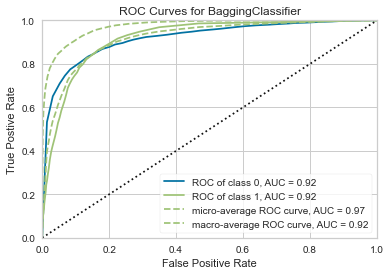

In [91]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(BaggingClassifier(n_estimators=50, max_samples= .7, bootstrap=True, oob_score=True, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

## GradientBoost Classifier Algorithm

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22) #0.002,0.05,0.15
gbcl = gbcl.fit(X_train, y_train)

pred_GB = gbcl.predict(X_test)


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['GradientBoost'], 'Accuracy': accuracy_score(y_test, pred_GB)
                         ,'Recall' : recall_score(y_test,pred_GB), 'Precision': precision_score(y_test,pred_GB)
                         ,'F1 Score' : f1_score(y_test,pred_GB), 'Roc Auc Score': roc_auc_score(y_test,pred_GB)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.900840,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.901430,0.339136,0.627685,0.440352,0.656582
0,Random Forest,0.905780,0.381689,0.649835,0.480910,0.677567
0,Adaboost,0.897744,0.208897,0.669421,0.318428,0.597789
0,Bagging,0.904895,0.466796,0.609941,0.528853,0.714127
0,GradientBoost,0.904453,0.355255,0.650531,0.459550,0.665307


C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


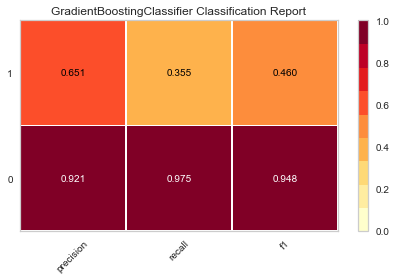

C:\Users\zehra.hussain\AppData\Local\Continuum\anaconda4\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


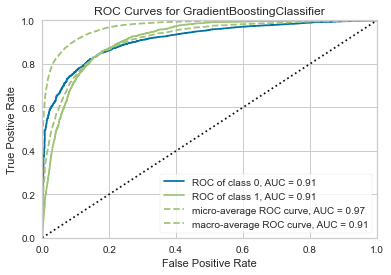

In [94]:
# Visualize model performance with yellowbrick library
viz = ClassificationReport(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

roc = ROCAUC(GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, random_state=22))
roc.fit(X_train, y_train)
roc.score(X_test, y_test)
roc.show()

## XG BOOST

In [96]:
XGB = XGBClassifier(max_depth=5)
XGB.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [97]:
pred_XGB = XGB.predict(X_test)


In [98]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'Accuracy': accuracy_score(y_test, pred_XGB)
                         ,'Recall' : recall_score(y_test,pred_XGB), 'Precision': precision_score(y_test,pred_XGB)
                         ,'F1 Score' : f1_score(y_test,pred_XGB), 'Roc Auc Score': roc_auc_score(y_test,pred_XGB)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.900840,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.901430,0.339136,0.627685,0.440352,0.656582
0,Random Forest,0.905780,0.381689,0.649835,0.480910,0.677567
0,Adaboost,0.897744,0.208897,0.669421,0.318428,0.597789
0,Bagging,0.904895,0.466796,0.609941,0.528853,0.714127
0,GradientBoost,0.904453,0.355255,0.650531,0.459550,0.665307
0,XGBoost,0.906960,0.495164,0.615878,0.548964,0.727645


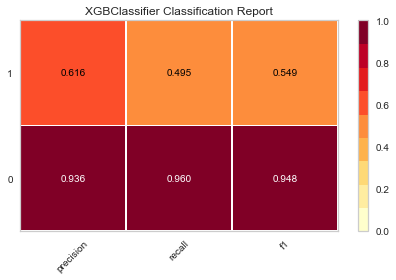

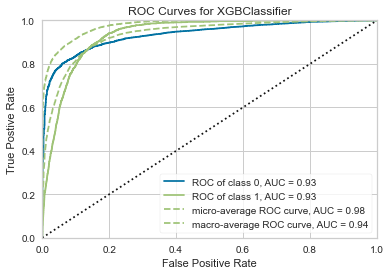

In [99]:
report = ClassificationReport(XGB, classes=['0','1'])
report.score(X_test, y_test)
c = report.poof()
rocauc = ROCAUC(XGB, classes=['0','1'])
rocauc.score(X_test, y_test)  
r = rocauc.poof()

# Conclusion 

XG Boost seems like the most optimal model in terms of Accuracy, Recall and F1 Score. Hence we would procced to tune this model.

## Parameter Tuning

In [125]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [126]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [127]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [128]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [129]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.9min finished


[12:55:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Time taken: 0 hours 2 minutes and 22.43 seconds.


In [130]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([17.84960516, 29.18030659, 26.05873076, 17.19323325, 21.22440489]), 'std_fit_time': array([0.20213658, 0.16126054, 1.18818235, 0.30846071, 0.15565582]), 'mean_score_time': array([0.21741859, 0.50897328, 0.48171536, 0.3949515 , 0.28291551]), 'std_score_time': array([0.00646305, 0.03100132, 0.0245207 , 0.01472588, 0.01178202]), 'param_subsample': masked_array(data=[1.0, 0.6, 0.8, 1.0, 0.8],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[5, 1, 5, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[3, 5, 5, 5, 4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[5, 1.5, 1, 5, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
         

In [134]:
RSXGB_test = random_search.predict(X_test)

In [135]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['RSXGBoost'], 'Accuracy': accuracy_score(y_test, RSXGB_test)
                         ,'Recall' : recall_score(y_test,RSXGB_test), 'Precision': precision_score(y_test,RSXGB_test)
                         ,'F1 Score' : f1_score(y_test,RSXGB_test), 'Roc Auc Score': roc_auc_score(y_test,RSXGB_test)})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'Accuracy','Recall', 'Precision','F1 Score', 'Roc Auc Score']]
resultsDf

,Method,Accuracy,Recall,Precision,F1 Score,Roc Auc Score
0,Logistic Regression,0.900840,0.338491,0.622038,0.438413,0.655968
0,Decision Tree,0.901430,0.339136,0.627685,0.440352,0.656582
0,Random Forest,0.905780,0.381689,0.649835,0.480910,0.677567
0,Adaboost,0.897744,0.208897,0.669421,0.318428,0.597789
0,Bagging,0.904895,0.466796,0.609941,0.528853,0.714127
0,GradientBoost,0.904453,0.355255,0.650531,0.459550,0.665307
0,XGBoost,0.906960,0.495164,0.615878,0.548964,0.727645
0,RSXGBoost,0.920894,0.509994,0.716486,0.595857,0.741969


# MODEL EVALUATION AND CONCLUSION

Precision is the number of correct positive results divided by the number of all positive results so how many of the people we predicted would have term deposits and actually had term deposits.

Recall is the number of correct positive results divided by the number of positive results that should have been returned so in this case that is how many of the toal term deposit customers did we accurately predict.

The F1 score is a measure of a test’s accuracy. It considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

precision = true positives / (true positives + false positives)

recall = true positives / (false negatives + true positives)

F1 score = 2 * ((precision * recall) / (precision + recall))

Based on the above summary table we would used the RSXGB model as it has the highest recall, precision and F1 Score.

In [2]:
import os

os.system('jupyter nbconvert --to html Ensemble Project_ZehraHussain.ipynb')

-1